# Neural system identification in Tensorflow

Let's develop a toy neural system ideintification test case in order to compare a direct model fitting method with classical STA approach (knowing "groud truth" data genrating model)...then let's try something new!

In [1]:
# import needed modules
import math
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.framework import ops

from skimage.filters import gabor_kernel
from skimage.transform import resize

%matplotlib inline

/usr/local/Anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Sythetic data generation
 

Let's start generating some synthetic "ideal" simple cell responses to noise stimulation

(16, 32, 40000)


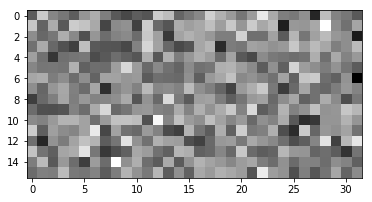

In [2]:
# generate uncorrelated noise stimulus for reverse correlation
nframes=40*1000
noise_width=32
noise_height=16
noise=np.random.randn(noise_height,noise_width,nframes)
noise=(noise-noise.mean())/(noise.max()-noise.min())

# inspect it
frame_to_be_inspected=noise[:,:,1]
plt.imshow(frame_to_be_inspected, cmap='gray')
print(noise.shape)

(16, 32, 40000)


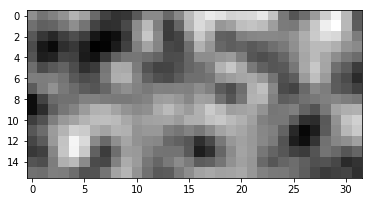

In [3]:
# generate correlated version of the noise
smooth_kernel=np.array([[1,2,1],[2,3,2],[1,2,1]])
smooth_kernel=np.reshape(smooth_kernel,(smooth_kernel.shape[0],smooth_kernel.shape[1],1))
corr_noise=sp.signal.convolve(noise, smooth_kernel, mode='valid')
corr_noise=resize(corr_noise, (noise_height,noise_width,nframes))
corr_noise=(corr_noise-corr_noise.min())/(corr_noise.max()-corr_noise.min())

# inspect it
frame_to_be_inspected=corr_noise[:,:,1]
plt.imshow(frame_to_be_inspected, cmap='gray')
print(corr_noise.shape)

(1, 512)
0.000207879451853


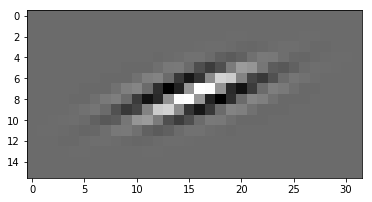

In [4]:
# create a gabor kernel
frequency=0.05 # spatial frequency in pixels
theta=(1/6)*math.pi # orientation in radians (0 on vertical axis)
sigma_x=10 # width std in pixel
sigma_y=20 # height std in pixel
n_stds=5 # number of stds in the output filters

# generate and resize kernel
flat_kernel = np.real(gabor_kernel(frequency, theta=theta,
                        sigma_x=sigma_x, sigma_y=sigma_y, n_stds=n_stds))
flat_kernel=resize(flat_kernel, (noise_height,noise_width))
kernel = np.reshape(flat_kernel,(1,noise_height*noise_width))

# inspect kernel
plt.imshow(flat_kernel, cmap='gray')
print(kernel.shape)
print(kernel.sum()) # what if you normalize the filter?

(1, 40000)


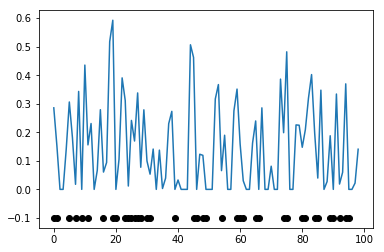

In [5]:
# generate synthetic responses
noise_to_use=corr_noise
kernel_response=np.dot(kernel,noise_to_use.reshape(noise_height*noise_width,nframes))
rectified_kernel_response=np.maximum(kernel_response,0)
scaled_rectified_kernel_response=(rectified_kernel_response/(np.max(rectified_kernel_response)))

# draw spike counts from a poisson process
psth=np.random.poisson(lam=5*scaled_rectified_kernel_response.flatten())

# visualize timestamps
timestamps=np.argwhere(psth[0:100]>0)
plt.plot(scaled_rectified_kernel_response.flatten()[1:100])
plt.plot(timestamps,-0.1*np.ones(timestamps.shape),'ko')
print(scaled_rectified_kernel_response.shape)

### System identification on synthetic data - brute force optimization
 
Now let's try to recover the linear kernel underlying our sinthetic data via direct model fitting

In [6]:
# split in training and test set
trainsetsize=int(nframes*0.8)
testsetsize=nframes-trainsetsize
n_x=noise_height*noise_width
n_y=1
x_train=noise_to_use[:,:,0:trainsetsize].reshape(n_x,trainsetsize)
x_test=noise_to_use[:,:,trainsetsize:nframes].reshape(n_x,testsetsize)
y_train=psth[0:trainsetsize].reshape(n_y,trainsetsize)
y_test=psth[trainsetsize:nframes].reshape(n_y,testsetsize)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(512, 32000)
(512, 8000)
(1, 32000)
(1, 8000)


In [7]:
# define parameters inizialization function
def initialize_params(n_x):
    W = tf.get_variable("W", [1,n_x], initializer = tf.random_uniform_initializer(minval=-1,maxval=1))
    g = tf.get_variable("g", [1,1], initializer = tf.random_uniform_initializer(minval=0,maxval=1))
    params = {"W": W,"g": g}
    return params
# TEST case
tf.reset_default_graph()
with tf.Session() as sess:
    params = initialize_params(n_x)
    print("W = " + str(params['W']))
    print("g = " + str(params['W']))

W = <tf.Variable 'W:0' shape=(1, 512) dtype=float32_ref>
g = <tf.Variable 'W:0' shape=(1, 512) dtype=float32_ref>


In [8]:
# define placeholder builder function
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    return X,Y
# TEST case
tf.reset_default_graph()
with tf.Session() as sess:
    (n_x, m) = x_train.shape                        
    (n_y, m)= y_train.shape 
    X,Y = create_placeholders(n_x, n_y)
    print("X = " + str(X))
    print("Y = " + str(Y))

X = Tensor("X:0", shape=(512, ?), dtype=float32)
Y = Tensor("Y:0", shape=(1, ?), dtype=float32)


In [9]:
def predict(x,params):
    W = params['W']
    g = params['g']
    # let's consider diverse temporal samples as training examples 
    # so as to vectorize with matmul
    y_predicted=tf.nn.relu(tf.matmul(W,x))
    y_predicted=g*tf.divide(y_predicted,tf.reduce_max(y_predicted, reduction_indices=[1])+1e-8)
    print(y_predicted)
    return y_predicted
# TEST case
tf.reset_default_graph()
with tf.Session() as sess:
    (n_x, m) = x_train.shape                        
    (n_y, m)= y_train.shape 
    params = initialize_params(n_x)
    X,Y = create_placeholders(n_x, n_y)
    Y_predicted=predict(X,params)
    print("Y_predicted = " + str(Y_predicted))

Tensor("mul:0", shape=(1, ?), dtype=float32)
Y_predicted = Tensor("mul:0", shape=(1, ?), dtype=float32)


In [10]:
# define cost function (over the whole batch)
def compute_cost(y_predicted,y):
    cost_vector=tf.pow(y-y_predicted, 2)
    cost = tf.reduce_mean(cost_vector,1)
    return cost
# TEST case
tf.reset_default_graph()
with tf.Session() as sess:
    (n_x, m) = x_train.shape                        
    (n_y, m)= y_train.shape 
    params = initialize_params(n_x)
    X,Y = create_placeholders(n_x, n_y)
    Y_predicted=predict(X,params)
    cost=compute_cost(Y_predicted,Y)
    print("cost = " + str(cost))

Tensor("mul:0", shape=(1, ?), dtype=float32)
cost = Tensor("Mean:0", shape=(1,), dtype=float32)


In [11]:
# define complete LN Tensorflow model using previously defined functions
def LN_model(x_train, y_train, x_test, y_test, learning_rate = 0.5,
          num_epochs = 10, print_cost = True):
    
    ops.reset_default_graph()   
    costs=[]
    
    (n_x, m) = x_train.shape                        
    (n_y, m)= y_train.shape 
    X,Y = create_placeholders(n_x, n_y)
    params = initialize_params(n_x)
    Y_predicted = predict(X,params) 
    cost=compute_cost(Y_predicted,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer() 
    with tf.Session() as sess:
        sess.run(init)   

        for epoch in range(num_epochs):
            _,epoch_cost=sess.run([optimizer, cost], feed_dict={X: x_train, Y: y_train})
            
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                costs.append(epoch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        params = sess.run(params)
        print("Parameters have been trained!")
        y_predicted=sess.run([Y_predicted], feed_dict={X: x_train, Y: y_train})
        y_predicted_test=sess.run([Y_predicted], feed_dict={X: x_test, Y: y_test})
    return params, y_predicted, y_predicted_test

Tensor("mul:0", shape=(1, ?), dtype=float32)
Cost after epoch 0: 2.060323
Cost after epoch 100: 1.183811
Cost after epoch 200: 0.876874
Cost after epoch 300: 0.839625
Cost after epoch 400: 0.799540
Cost after epoch 500: 0.798535
Cost after epoch 600: 0.780859
Cost after epoch 700: 0.786763
Cost after epoch 800: 0.778249
Cost after epoch 900: 0.779423
Cost after epoch 1000: 0.783786
Cost after epoch 1100: 0.767289
Cost after epoch 1200: 0.777504
Cost after epoch 1300: 0.771154
Cost after epoch 1400: 0.766740


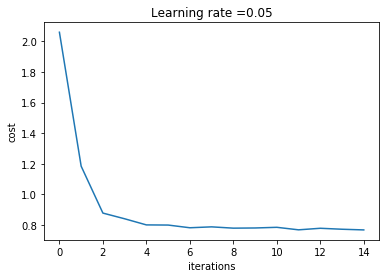

Parameters have been trained!
------------------------------------------
training set rsquare = 0.48
test set rsquare = 0.475
total spikes used = 30696


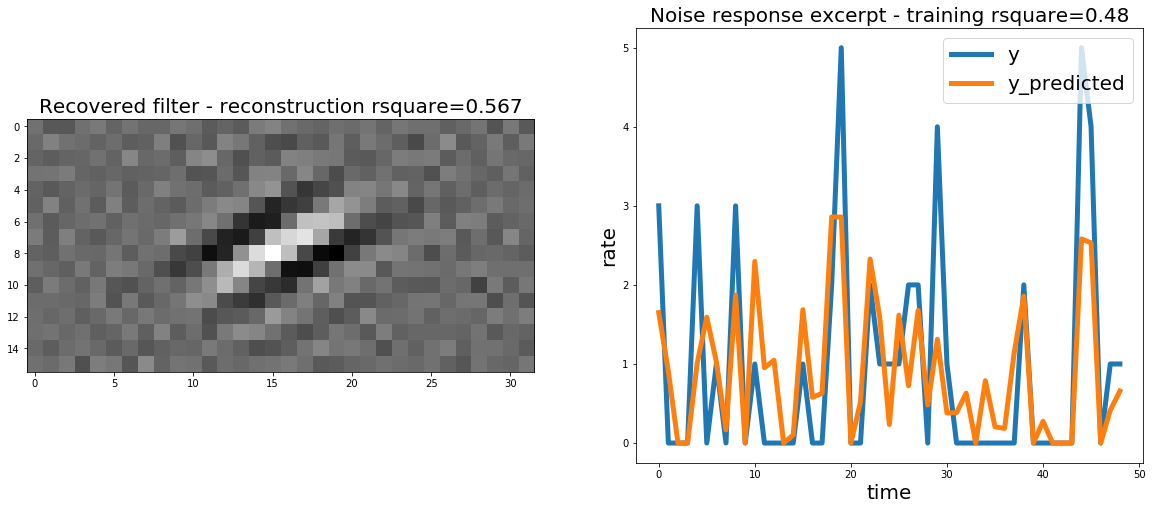

In [12]:
# run the model optimization (fit our linear model to the data)
optimal_params, y_predicted, y_predicted_test = LN_model(x_train, y_train, x_test, y_test, 
                                     num_epochs = 1500, learning_rate=0.05, print_cost=True)
# quantify training test and kernel reconstruction rsquare
train_rsq=np.square(sp.stats.pearsonr(y_predicted[0].flatten(),y_train.flatten()))[0]
test_rsq=np.square(sp.stats.pearsonr(y_predicted_test[0].flatten(),y_test.flatten()))[0]
reconstruction_rsq=np.square(sp.stats.pearsonr(kernel.flatten(),
                                               optimal_params['W'].flatten()))[0]
# inspect kernel
reconstructed_kernel = np.reshape(optimal_params['W'],(noise_height,noise_width))

# inspect results
print('------------------------------------------')
print("training set rsquare = "+str(round(train_rsq,3)))
print("test set rsquare = "+str(round(test_rsq,3)))
print("total spikes used = "+str(round(psth.sum(),3)))
fig = plt.figure(figsize=(20, 8))
fig.add_subplot(1,2,1)
a=plt.imshow( reconstructed_kernel , cmap='gray')
plt.title("Recovered filter - reconstruction rsquare="+str(round(reconstruction_rsq,3)),fontsize=20)
b=fig.add_subplot(1,2,2)
plt.plot(psth[1:50], lw=5, label='y')
plt.plot(y_predicted[0].flatten()[1:50], lw=5, label='y_predicted')
plt.ylabel('rate',fontsize=20)
plt.xlabel('time',fontsize=20)
b.legend(loc=1,prop={'size': 20})
plt.title("Noise response excerpt - training rsquare="+str(round(train_rsq,3)),fontsize=20)

### System identification on synthetic data - spike triggered average
Now let's try to recover the linear kernel underlying our sinthetic data via direct model fitting and compare with prevous method results ... 

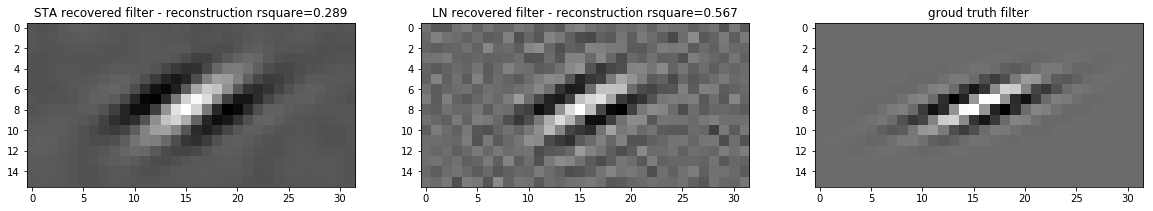

In [13]:
# compute spike triggeread average
sea=np.reshape(np.mean(x_train,1),(noise_height,noise_width))
sta=np.reshape(np.mean(x_train*y_train,1),(noise_height,noise_width))-sea
# quantify kernel reconstruction rsquare
sta_reconstruction_rsq=np.square(sp.stats.pearsonr(kernel.flatten(),sta.flatten()))[0]

# display results
fig = plt.figure(figsize=(20, 8))
fig.add_subplot(1,3,1)
a=plt.imshow( sta , cmap='gray')
plt.title("STA recovered filter - reconstruction rsquare="+str(round(sta_reconstruction_rsq,3)),fontsize=12)
fig.add_subplot(1,3,2)
a=plt.imshow( reconstructed_kernel , cmap='gray')
plt.title("LN recovered filter - reconstruction rsquare="+str(round(reconstruction_rsq,3)),fontsize=12)
fig.add_subplot(1,3,3)
a=plt.imshow( flat_kernel , cmap='gray')
plt.title('groud truth filter',fontsize=12)

### System identification via feature visualization 
Let's now try something different: let's try to recover the ground truth filter with a feature visualization approach (i.e. directly optimizing pixel grayscale values of a noise input image to maximize the activation of our simple LN model)

In [14]:
# define stimulus inizialization function
def initialize_stimulus(n_x):

    X = tf.get_variable("X", [n_x,1], 
                        initializer = tf.random_uniform_initializer(minval=0,maxval=1),
                        trainable=True)
    return X
# TEST case
tf.reset_default_graph()
with tf.Session() as sess:
    X = initialize_stimulus(n_x)
    print("X = " + str(X))

X = <tf.Variable 'X:0' shape=(512, 1) dtype=float32_ref>


In [15]:
# define placeholder builder function
def create_placeholder_bis(n_x):
    W = tf.placeholder(tf.float32, [1, n_x], name="W")
    g = tf.placeholder(tf.float32, [1, 1], name="g")
    return W,g
# TEST case
tf.reset_default_graph()
with tf.Session() as sess:
    (n_x, m) = x_train.shape                        
    W,g = create_placeholder_bis(n_x)
    print("W = " + str(W))
    print("g = " + str(g))

W = Tensor("W:0", shape=(1, 512), dtype=float32)
g = Tensor("g:0", shape=(1, 1), dtype=float32)


In [16]:
def predict_bis (x,W,g):
    # similar as in the original model but without normalization (g is not used > to be removed)
    #y_predicted=tf.nn.relu(tf.matmul(W,x))
    y_predicted=tf.nn.relu(tf.matmul(W,x))
    print(y_predicted)
    return y_predicted
# TEST case
tf.reset_default_graph()
with tf.Session() as sess:
    (n_x, m) = x_train.shape                        
    X = initialize_stimulus(n_x)
    W,g = create_placeholder_bis(n_x)
    Y_predicted=predict_bis(X,W,g)
    print("Y_predicted = " + str(Y_predicted))

Tensor("Relu:0", shape=(1, 1), dtype=float32)
Y_predicted = Tensor("Relu:0", shape=(1, 1), dtype=float32)


In [76]:
# define cost function (over the whole batch)
def compute_cost_bis(Y_predicted,X,noise_height=16,noise_width=32,lambda_sparse=1,lambda_smooth=1):
    
    # convert shape into: 1 x height x width x 1.
    X_resized = tf.expand_dims(tf.expand_dims(tf.reshape(X,[noise_height,noise_width]), 0), 3)
    laplace_filter = tf.expand_dims(tf.expand_dims(tf.constant([[0, -1, 0], [-1, 4, -1],
                                                                [0, -1, 0]], tf.float32), 2), 3)
    filtered_X = tf.nn.conv2d(X_resized, laplace_filter,
                          strides=[1, 1, 1, 1], padding='SAME')
    sparsity_regularizer = lambda_sparse * tf.reduce_sum(tf.abs(tf.reshape(X_resized-0.5, [-1])))
    smoothness_regularizer = lambda_smooth * tf.sqrt(tf.reduce_sum(tf.square(tf.reshape(filtered_X, [-1]))))
    cost = -Y_predicted +sparsity_regularizer +smoothness_regularizer
    
    return cost
# TEST case
tf.reset_default_graph()
with tf.Session() as sess:
    (n_x, m) = x_train.shape                        
    X = initialize_stimulus(n_x)
    W,g = create_placeholder_bis(n_x)
    Y_predicted=predict_bis(X,W,g)
    cost=compute_cost_bis(Y_predicted,X,noise_height=noise_height,
                          noise_width=noise_width,lambda_sparse=1,lambda_smooth=1)
    print("cost = " + str(cost))

Tensor("Relu:0", shape=(1, 1), dtype=float32)
cost = Tensor("add_1:0", shape=(1, 1), dtype=float32)


In [77]:
# define complete optimal stimulus generator using previously defined functions
def optimal_stimulus_generator(params, noise_height=16, noise_width=32, learning_rate = 0.1,
          num_epochs = 10, lambda_sparse=0.01, lambda_smooth=0.5, print_cost = True):
    
    n_x=noise_height*noise_width
    ops.reset_default_graph()   
    costs=[]
    
    # define placeholders for parameters
    W,g = create_placeholder_bis(n_x)
    
    # initialize stimulus
    X=initialize_stimulus(n_x)
    
    # enforce the constraint that X has to be a [0,1] grayscale image
    X=tf.where(tf.less(tf.ones_like(X),X),tf.ones_like(X),X)
    X=tf.where(tf.less(X,tf.zeros_like(X)),tf.zeros_like(X),X)
    
    # compute activation
    Y_predicted = predict_bis(X,W,g) 
    
    # define cost as - activation (we want to maximize activation)
    cost=compute_cost_bis(Y_predicted,X,noise_height=noise_height,
                         noise_width=noise_width,lambda_sparse=lambda_sparse,lambda_smooth=lambda_smooth)
    
    # set optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer() 
    with tf.Session() as sess:
        sess.run(init)   

        for epoch in range(num_epochs):
            #print(sess.run([Y_predicted], feed_dict={W:params['W'],g:params['g']}))
            _,epoch_cost=sess.run([optimizer, cost], feed_dict={W:params['W'],g:params['g']})
            
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                costs.append(epoch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        print("Parameters have been trained!")
        optimal_stimulus=sess.run(X, feed_dict={W:params['W'],g:params['g']})
        
        return optimal_stimulus

Tensor("Relu:0", shape=(1, 1), dtype=float32)
Cost after epoch 0: 216.597702
Cost after epoch 100: 151.242889
Cost after epoch 200: 96.823357
Cost after epoch 300: 54.370075
Cost after epoch 400: 30.053566
Cost after epoch 500: 9.960070
Cost after epoch 600: 1.092924
Cost after epoch 700: -4.365829
Cost after epoch 800: -7.317543
Cost after epoch 900: -9.204411
Cost after epoch 1000: -10.204411
Cost after epoch 1100: -10.591759
Cost after epoch 1200: -10.753559
Cost after epoch 1300: -10.815559
Cost after epoch 1400: -10.845558


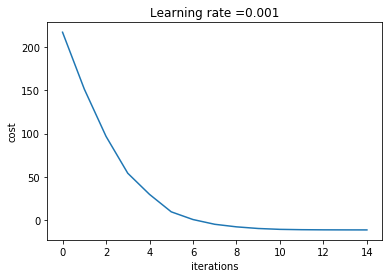

Parameters have been trained!


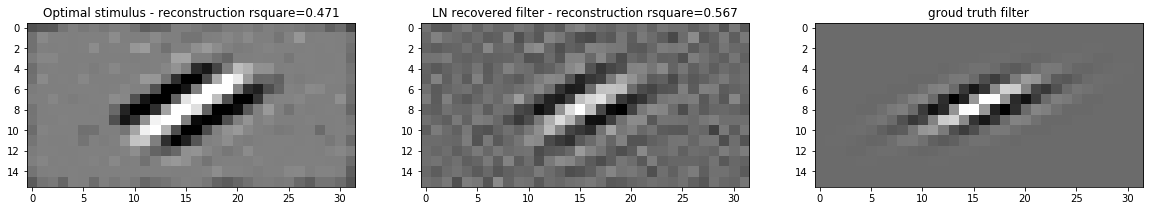

In [85]:
# run the model optimization (fit our linear model to the data)
optimal_stimulus = optimal_stimulus_generator(optimal_params, noise_height=noise_height, 
          noise_width=noise_width, learning_rate = 0.001,
          num_epochs = 1500, print_cost = True, lambda_sparse=0.5, lambda_smooth=5)
# regape optimal stimulus
opfeat=np.reshape(optimal_stimulus,(noise_height,noise_width))
# quantify kernel reconstruction rsquare
optimal_stimulus_rsq=np.square(sp.stats.pearsonr(kernel.flatten(),opfeat.flatten()))[0]

# display results
fig = plt.figure(figsize=(20, 8))
fig.add_subplot(1,3,1)
a=plt.imshow( opfeat , cmap='gray')
plt.title("Optimal stimulus - reconstruction rsquare="+str(round(optimal_stimulus_rsq,3)),fontsize=12)
fig.add_subplot(1,3,2)
a=plt.imshow( reconstructed_kernel , cmap='gray')
plt.title("LN recovered filter - reconstruction rsquare="+str(round(reconstruction_rsq,3)),fontsize=12)
fig.add_subplot(1,3,3)
a=plt.imshow( flat_kernel , cmap='gray')
plt.title('groud truth filter',fontsize=12)